In [3]:
import sympy as sp
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from tools import downsample_data

Now we will consider the triple pendulum. Taking the setup in 'double_pendulum.ipynb', as a reference, it is natural to observe that:
\begin{align}
U_1&=m_1gh_1=m_1gl_1(1-\cos(\phi_1)) \\
U_2&=m_2g(h_1+h_2)=m_2g\Big[l_1(1-\cos(\phi_1))+l_2(1-\cos(\phi_2))\Big] \\
U_3&=m_3g(h_1+h_2+h_3)=m_3g\Big[l_1(1-\cos(\phi_1))+l_2(1-\cos(\phi_2))+l_3(1-\cos(\phi_3))\Big]
\end{align}
with $U=U_1+U_2+U_3$. However instead of taking the approach as in 'double_pendulum.ipynb' for determining the velocities of the particles, we will instead utilize the standard coordinate transformation between cartesian and polar coordinates in 2D:
\begin{equation}
\hat{r}=\hat{x}\cos{\phi}+\hat{y}\sin(\phi)
\end{equation}
and define the coordinates of the three masses as:
\begin{equation}
\vec{r}_1&=\hat{x}l_1\sin(\phi_1)-\hat{y}l_1\cos(\phi_1) \\
\vec{r}_2&=\hat{x}\big(l_1\sin(\phi_1)+l_2\sin(\phi_2)\big)-\hat{y}\big(l_1\cos(\phi_1)+l_2\cos(\phi_2)\big) \\
\vec{r}_3&=\hat{x}\big(l_1\sin(\phi_1)+l_2\sin(\phi_2)+l_3\sin(\phi_3)\big)-\hat{y}\big(l_1\cos(\phi_1)+l_2\cos(\phi_2)+l_3\cos(\phi_3)\big)
\end{equation}


In [4]:
# Define the symbols
t = sp.symbols('t')  # time
m1, m2, m3, l1, l2, l3, g = sp.symbols('m1 m2 m3 l1 l2 l3 g')        # masses, lengths, gravitational acceleration
phi1, phi2, phi3 = sp.symbols('phi1 phi2 phi3', cls=sp.Function)     # angles as functions of time

# Define the angle functions and their derivatives
phi1, phi2, phi3 = phi1(t), phi2(t), phi3(t)
phi1_dot, phi2_dot, phi3_dot = sp.diff(phi1, t), sp.diff(phi2, t), sp.diff(phi3, t)

x1, y1 = l1*sp.sin(phi1)                                , -l1*sp.cos(phi1)
x2, y2 = l1*sp.sin(phi1)+l2*sp.sin(phi2)                , -l1*sp.cos(phi1)-l2*sp.cos(phi2)
x3, y3 = l1*sp.sin(phi1)+l2*sp.sin(phi2)+l3*sp.sin(phi3), -l1*sp.cos(phi1)-l2*sp.cos(phi2)-l3*sp.cos(phi3)

vx1, vy1 = sp.diff(x1,t), sp.diff(y1,t)
vx2, vy2 = sp.diff(x2,t), sp.diff(y2,t)
vx3, vy3 = sp.diff(x3,t), sp.diff(y3,t)

T_1 = sp.Rational(1,2) * m1 * (vx1**2 + vy1**2)
T_2 = sp.Rational(1,2) * m2 * (vx2**2 + vy2**2)
T_3 = sp.Rational(1,2) * m2 * (vx3**2 + vy3**2)
T = T_1 + T_2 + T_3

U_1 = m1*g*l1*(1-sp.cos(phi1))
U_2 = m2*g*(l1*(1-sp.cos(phi1))+l2*(1-sp.cos(phi2)))
U_3 = m3*g*(l1*(1-sp.cos(phi1))+l2*(1-sp.cos(phi2))+l3*(1-sp.cos(phi3)))
U = U_1 + U_2 + U_3

L = T-U


In [5]:
# Apply the Euler-Lagrange equation
EL1 = sp.diff(sp.diff(L, phi1_dot), t) - sp.diff(L, phi1)
EL2 = sp.diff(sp.diff(L, phi2_dot), t) - sp.diff(L, phi2)
EL3 = sp.diff(sp.diff(L, phi3_dot), t) - sp.diff(L, phi3)

# Optionally, simplify the equations
EL1_simplified = sp.Eq(sp.simplify(EL1),0)
EL2_simplified = sp.Eq(sp.simplify(EL2),0)
EL3_simplified = sp.Eq(sp.simplify(EL3),0)

In [6]:
# Defining the second order time deriv variables
phi1_ddot, phi2_ddot, phi3_ddot = sp.diff(phi1, t, t), sp.diff(phi2, t, t), sp.diff(phi3, t, t)
# Solving the system of EL equations for the second order time derivatives
# N.B. Solutions is a dict: variable -> equation
solutions = sp.solve([EL1_simplified, EL2_simplified, EL3_simplified], (phi1_ddot, phi2_ddot, phi3_ddot))

In [7]:
# Turning the second order equations into vectorized numpy functions that can efficiently evaluate numerical values
phi1_ddot_lambdified = sp.lambdify([m1, m2, m3, 
                                    l1, l2, l3, 
                                    phi1, phi2, phi3, 
                                    phi1_dot, phi2_dot, phi3_dot,
                                    g], solutions[phi1_ddot], 'numpy')
phi2_ddot_lambdified = sp.lambdify([m1, m2, m3, 
                                    l1, l2, l3, 
                                    phi1, phi2, phi3, 
                                    phi1_dot, phi2_dot, phi3_dot,
                                    g], solutions[phi2_ddot], 'numpy')
phi3_ddot_lambdified = sp.lambdify([m1, m2, m3, 
                                    l1, l2, l3, 
                                    phi1, phi2, phi3, 
                                    phi1_dot, phi2_dot, phi3_dot,
                                    g], solutions[phi3_ddot], 'numpy')

# Wrapping in outer function to make more recognizable 
def d2_phi_1_dt2(phi_1:float, d_phi_1_dt: float, 
                 phi_2:float, d_phi_2_dt: float,
                 phi_3:float, d_phi_3_dt: float,
                 length_1: float, length_2: float, length_3: float, 
                 mass_1: float, mass_2: float, mass_3: float, 
                 g: float):
    return phi1_ddot_lambdified(mass_1, mass_2, mass_3, 
                                length_1, length_2, length_3,
                                phi_1, phi_2, phi_3,
                                d_phi_1_dt, d_phi_2_dt, d_phi_3_dt,
                                g)

def d2_phi_2_dt2(phi_1:float, d_phi_1_dt: float, 
                 phi_2:float, d_phi_2_dt: float,
                 phi_3:float, d_phi_3_dt: float,
                 length_1: float, length_2: float, length_3: float, 
                 mass_1: float, mass_2: float, mass_3: float, 
                 g: float):
    return phi2_ddot_lambdified(mass_1, mass_2, mass_3, 
                                length_1, length_2, length_3,
                                phi_1, phi_2, phi_3,
                                d_phi_1_dt, d_phi_2_dt, d_phi_3_dt,
                                g)

def d2_phi_3_dt2(phi_1:float, d_phi_1_dt: float, 
                 phi_2:float, d_phi_2_dt: float,
                 phi_3:float, d_phi_3_dt: float,
                 length_1: float, length_2: float, length_3: float, 
                 mass_1: float, mass_2: float, mass_3: float, 
                 g: float):
    return phi3_ddot_lambdified(mass_1, mass_2, mass_3, 
                                length_1, length_2, length_3,
                                phi_1, phi_2, phi_3,
                                d_phi_1_dt, d_phi_2_dt, d_phi_3_dt,
                                g)

In [27]:
# Define the ODE function
def double_pendulum(t, y, l1, l2, l3, m1, m2, m3, g):
    phi_1, d_phi_1_dt, phi_2, d_phi_2_dt, phi_3, d_phi_3_dt = y
    d2_phi_1_dt2_value = d2_phi_1_dt2(phi_1=phi_1, d_phi_1_dt=d_phi_1_dt,
                                      phi_2=phi_2, d_phi_2_dt=d_phi_2_dt,
                                      phi_3=phi_3, d_phi_3_dt=d_phi_3_dt,
                                      length_1=l1, length_2=l2, length_3=l3,
                                      mass_1=m1, mass_2=m2, mass_3=m3, g=g)
    
    d2_phi_2_dt2_value = d2_phi_2_dt2(phi_1=phi_1, d_phi_1_dt=d_phi_1_dt,
                                      phi_2=phi_2, d_phi_2_dt=d_phi_2_dt,
                                      phi_3=phi_3, d_phi_3_dt=d_phi_3_dt,
                                      length_1=l1, length_2=l2, length_3=l3,
                                      mass_1=m1, mass_2=m2, mass_3=m3, g=g)
    
    d2_phi_3_dt2_value = d2_phi_3_dt2(phi_1=phi_1, d_phi_1_dt=d_phi_1_dt,
                                      phi_2=phi_2, d_phi_2_dt=d_phi_2_dt,
                                      phi_3=phi_3, d_phi_3_dt=d_phi_3_dt,
                                      length_1=l1, length_2=l2, length_3=l3,
                                      mass_1=m1, mass_2=m2, mass_3=m3, g=g)
    
    return [d_phi_1_dt, d2_phi_1_dt2_value, 
            d_phi_2_dt, d2_phi_2_dt2_value, 
            d_phi_3_dt, d2_phi_3_dt2_value]

# Initial conditions
phi_1_init, phi_2_init, phi_3_init = np.pi/4, np.pi/3, np.pi
phi_1_dot_init, phi_2_dot_init, phi_3_dot_init = 0, 0, 0
initial_conditions = [phi_1_init, phi_1_dot_init,
                      phi_2_init, phi_2_dot_init,
                      phi_3_init, phi_3_dot_init]  

# Parameters
l1, l2, l3 = 1.2, 1.3, 0.7
m1, m2, m3 = 1,1,1
g = 9.82
params = (l1, l2, l3, m1, m2, m3, g)  

# Time span for the simulation
t_min, t_max = 0, 30
n_times = int(t_max*2000)

time_span = np.linspace(start=t_min, stop=t_max, num=n_times)

# Solve the ODEs
solution = sc.integrate.solve_ivp(fun=double_pendulum,
                        t_span=(t_min,t_max),
                        y0=initial_conditions,
                        method='Radau',
                        args=params,
                        t_eval=time_span)

print(solution.message)

The solver successfully reached the end of the integration interval.


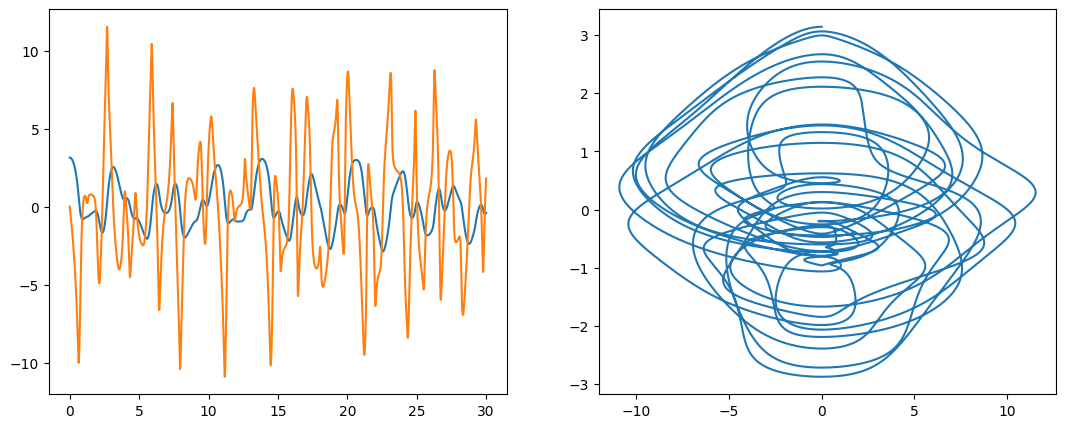

In [28]:
_, __, ___, ____, lower_pendulum_angles, lower_pendulum_angle_velocities = solution.y

fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(solution.t, lower_pendulum_angles)
ax[0].plot(solution.t, lower_pendulum_angle_velocities)
ax[1].plot(lower_pendulum_angle_velocities, lower_pendulum_angles)

In [29]:
def get_energies(solver_result: sc.integrate._ivp.ivp.OdeResult,
                 mass1: float, mass2: float, mass3: float,
                 length1: float, length2: float, length3: float,
                 gravity: float):
    # Define the symbols
    t = sp.symbols('t')  # time
    m1, m2, m3, l1, l2, l3, g = sp.symbols('m1 m2 m3 l1 l2 l3 g')        # masses, lengths, gravitational acceleration
    phi1, phi2, phi3 = sp.symbols('phi1 phi2 phi3', cls=sp.Function)     # angles as functions of time
    
    # Define the angle functions and their derivatives
    phi1, phi2, phi3 = phi1(t), phi2(t), phi3(t)
    phi1_dot, phi2_dot, phi3_dot = sp.diff(phi1, t), sp.diff(phi2, t), sp.diff(phi3, t)
    
    x1, y1 = l1*sp.sin(phi1)                                , -l1*sp.cos(phi1)
    x2, y2 = l1*sp.sin(phi1)+l2*sp.sin(phi2)                , -l1*sp.cos(phi1)-l2*sp.cos(phi2)
    x3, y3 = l1*sp.sin(phi1)+l2*sp.sin(phi2)+l3*sp.sin(phi3), -l1*sp.cos(phi1)-l2*sp.cos(phi2)-l3*sp.cos(phi3)
    
    vx1, vy1 = sp.diff(x1,t), sp.diff(y1,t)
    vx2, vy2 = sp.diff(x2,t), sp.diff(y2,t)
    vx3, vy3 = sp.diff(x3,t), sp.diff(y3,t)
    
    T_1 = sp.Rational(1,2) * m1 * (vx1**2 + vy1**2)
    T_2 = sp.Rational(1,2) * m2 * (vx2**2 + vy2**2)
    T_3 = sp.Rational(1,2) * m2 * (vx3**2 + vy3**2)
    T = T_1 + T_2 + T_3
    
    U_1 = m1*g*l1*(1-sp.cos(phi1))
    U_2 = m2*g*(l1*(1-sp.cos(phi1))+l2*(1-sp.cos(phi2)))
    U_3 = m3*g*(l1*(1-sp.cos(phi1))+l2*(1-sp.cos(phi2))+l3*(1-sp.cos(phi3)))
    U = U_1 + U_2 + U_3

    # Lambdify the energy expressions
    T_func = sp.lambdify([m1, m2, m3,
                          l1, l2, l3,
                          phi1, phi2, phi3,
                          phi1_dot, phi2_dot, phi3_dot, g], T, 'numpy')
    
    U_func = sp.lambdify([m1, m2, m3,
                          l1, l2, l3,
                          phi1, phi2, phi3,
                          phi1_dot, phi2_dot, phi3_dot, g], U, 'numpy')

    # Extract the solver's results
    phi_1_values, phi_1_dot_values, phi_2_values, phi_2_dot_values, phi_3_values, phi_3_dot_values = solver_result.y

    # Calculate energies
    kinetic_energies = T_func(mass1, mass2, mass3,
                              length1, length2, length3,
                              phi_1_values, phi_2_values, phi_3_values,
                              phi_1_dot_values, phi_2_dot_values, phi_3_dot_values, gravity)
    
    potential_energies = U_func(mass1, mass2, mass3,
                              length1, length2, length3,
                              phi_1_values, phi_2_values, phi_3_values,
                              phi_1_dot_values, phi_2_dot_values, phi_3_dot_values, gravity)

    return kinetic_energies, potential_energies


def get_cartesian_coordinates(solver_result: sc.integrate._ivp.ivp.OdeResult,
                              length_1: float,
                              length_2: float,
                              length_3: float):
    def angle_to_xy(angle: float, distance: float):
        return np.array([distance * np.sin(angle), -distance * np.cos(angle)])

        # Extract the solver's results

    phi_upper, _, phi_middle, __, phi_lower, ___ = solver_result.y

    times = solver_result.t
    upper_pendulum = np.array([angle_to_xy(angle=phi, distance=length_1).tolist() for phi in phi_upper])
    middle_pendulum = np.array(
        [(angle_to_xy(angle=phi_middle[i], distance=length_2) + upper_pendulum[i]).tolist() for i in
         range(len(phi_middle))])
    lower_pendulum = np.array(
        [(angle_to_xy(angle=phi_lower[i], distance=length_3) + middle_pendulum[i]).tolist() for i in
         range(len(phi_lower))])

    return upper_pendulum, middle_pendulum, lower_pendulum, times

In [30]:
kinetic_energies, potential_energies = get_energies(solver_result=solution,
                                                    mass1=m1, mass2=m2, mass3=m3,
                                                    length1=l1, length2=l2, length3=l3,
                                                    gravity=g)

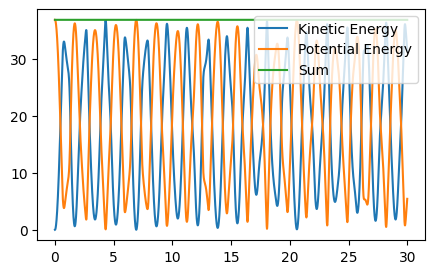

In [31]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(solution.t, kinetic_energies, label='Kinetic Energy')
ax.plot(solution.t, potential_energies, label='Potential Energy')
ax.plot(solution.t, potential_energies+kinetic_energies, label='Sum')
ax.legend(loc=1)
plt.show()


In [32]:
_upper_pendulum_, _middle_pendulum_, _lower_pendulum_, _times_ = get_cartesian_coordinates(solver_result=solution,
                                                                                   length_1=l1, length_2=l2, length_3=l3)
sample_rate = 1
upper_pendulum, middle_pendulum, lower_pendulum, times = _upper_pendulum_[::sample_rate], _middle_pendulum_[::sample_rate], _lower_pendulum_[::sample_rate], _times_[::sample_rate]

"""upper_pendulum, middle_pendulum, lower_pendulum, times = _upper_pendulum_, _middle_pendulum_, _lower_pendulum_, _times_"""

'upper_pendulum, middle_pendulum, lower_pendulum, times = _upper_pendulum_, _middle_pendulum_, _lower_pendulum_, _times_'

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1500x1500', '-pix_fmt', 'rgba', '-r', '100', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'artist=Sebastian Yde', '-y', 'triple_pendulum_animation.mp4']' returned non-zero exit status 255.

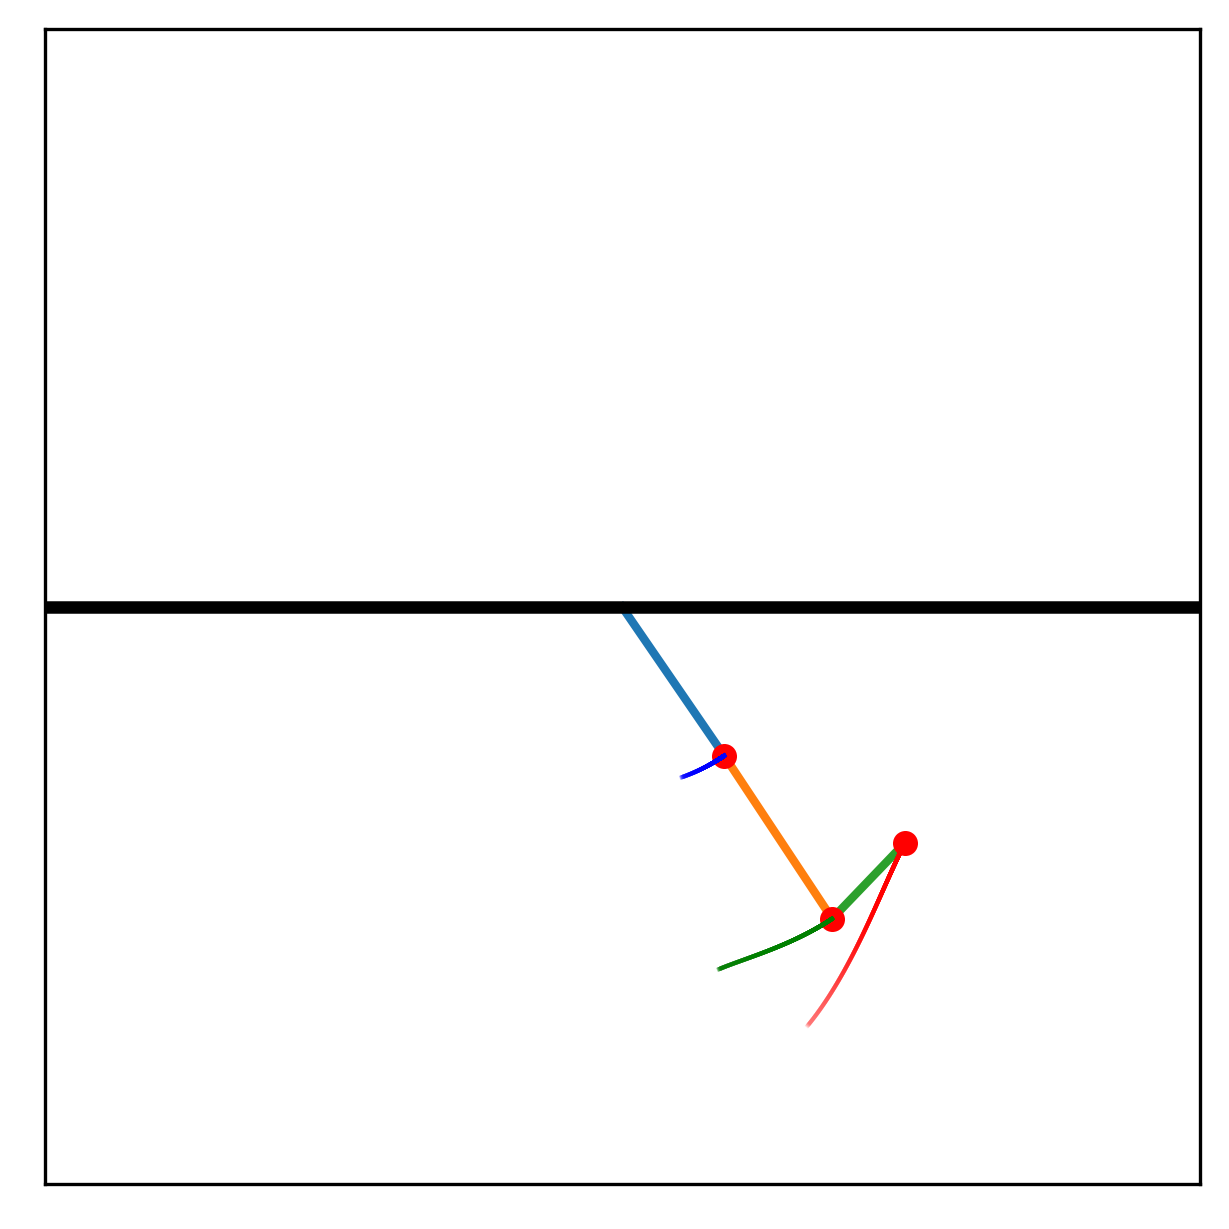

In [33]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation


resolution = 300
fig, ax = plt.subplots(figsize=(5, 5), dpi=resolution)

# Initial plot elements
line1, = ax.plot([], [], lw=2)  # Line for the upper arm
line2, = ax.plot([], [], lw=2)  # Line for the middle arm
line3, = ax.plot([], [], lw=2)  # Line for the lower arm
point1, = ax.plot([], [], 'ro', ms=5)  # Point for the upper pendulum
point2, = ax.plot([], [], 'ro', ms=5)  # Point for the middle pendulum
point3, = ax.plot([], [], 'ro', ms=5)  # Point for the lower pendulum

# Store the trace data as lists of line segments
trace_segments_upper = []
trace_segments_middle = []
trace_segments_lower = []

# Parameters for the trace
trace_length = 500  # Adjust as needed
fade_factor = 0.995  # Adjust for different fading speeds
fade_trace = True  # Set to False to disable fading

# Initialization function
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    point1.set_data([], [])
    point2.set_data([], [])
    point3.set_data([], [])
    return line1, line2, line3, point1, point2, point3

# Animation update function
def update(idx):
    # Upper arm
    line1.set_data([0, upper_pendulum[idx, 0]], [0, upper_pendulum[idx, 1]])
    point1.set_data(upper_pendulum[idx, 0], upper_pendulum[idx, 1])

    # Middle arm
    line2.set_data([upper_pendulum[idx, 0], middle_pendulum[idx, 0]], [upper_pendulum[idx, 1], middle_pendulum[idx, 1]])
    point2.set_data(middle_pendulum[idx, 0], middle_pendulum[idx, 1])
    
    # Lower arm
    line3.set_data([middle_pendulum[idx, 0], lower_pendulum[idx, 0]], [middle_pendulum[idx, 1], lower_pendulum[idx, 1]])
    point3.set_data(lower_pendulum[idx, 0], lower_pendulum[idx, 1])

    # Update trace for upper pendulum
    if idx > 0:
        new_segment_upper, = ax.plot([upper_pendulum[idx-1, 0], upper_pendulum[idx, 0]],
                                     [upper_pendulum[idx-1, 1], upper_pendulum[idx, 1]], 
                                     color='blue', lw=1, alpha=1)
        trace_segments_upper.append(new_segment_upper)

        # Update trace for middle pendulum
        new_segment_middle, = ax.plot([middle_pendulum[idx-1, 0], middle_pendulum[idx, 0]],
                                      [middle_pendulum[idx-1, 1], middle_pendulum[idx, 1]], 
                                      color='green', lw=1, alpha=1)
        trace_segments_middle.append(new_segment_middle)

        # Update trace for lower pendulum
        new_segment_lower, = ax.plot([lower_pendulum[idx-1, 0], lower_pendulum[idx, 0]],
                                     [lower_pendulum[idx-1, 1], lower_pendulum[idx, 1]], 
                                     color='red', lw=1, alpha=1)
        trace_segments_lower.append(new_segment_lower)

        # Fade older segments if fade_trace is True
        if fade_trace:
            for segment in trace_segments_upper[:-1]:  # Exclude the newest segment
                alpha = segment.get_alpha() * fade_factor
                segment.set_alpha(alpha)

            for segment in trace_segments_middle[:-1]:  # Exclude the newest segment
                alpha = segment.get_alpha() * fade_factor
                segment.set_alpha(alpha)

            for segment in trace_segments_lower[:-1]:  # Exclude the newest segment
                alpha = segment.get_alpha() * fade_factor
                segment.set_alpha(alpha)

        # Remove the oldest segment if trace is too long
        if len(trace_segments_upper) > trace_length:
            old_segment_upper = trace_segments_upper.pop(0)
            old_segment_upper.remove()

        if len(trace_segments_middle) > trace_length:
            old_segment_middle = trace_segments_middle.pop(0)
            old_segment_middle.remove()

        if len(trace_segments_lower) > trace_length:
            old_segment_lower = trace_segments_lower.pop(0)
            old_segment_lower.remove()

    return [line1, line2, line3, point1, point2, point3] + trace_segments_upper + trace_segments_middle + trace_segments_lower

# Setting additional things
ax.set_xlim(-1.2*(l1+l2+l3), 1.2*(l1+l2+l3))
ax.set_ylim(-1.2*(l1+l2+l3), 1.2*(l1+l2+l3))
ax.set_aspect('equal')
ax.hlines(0, -1.2*(l1+l2+l3), 1.2*(l1+l2+l3), lw=3, color='k')

# Remove axis ticks and labels
ax.set_xticks([]), ax.set_yticks([])
ax.set_xlabel(''), ax.set_ylabel('')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(times), init_func=init, blit=True, interval=1)

# Set up the writer
Writer = animation.writers['ffmpeg']
writer = Writer(fps=100, metadata=dict(artist='Sebastian Yde'))

# Save the animation
ani.save('triple_pendulum_animation.mp4', writer=writer)

plt.close(fig)